In [1]:
def args_type(default):
  def parse_string(x):
    if default is None:
      return x
    if isinstance(default, bool):
      return bool(['False', 'True'].index(x))
    if isinstance(default, int):
      return float(x) if ('e' in x or '.' in x) else int(x)
    if isinstance(default, (list, tuple)):
      return tuple(args_type(default[0])(y) for y in x.split(','))
    return type(default)(x)
  def parse_object(x):
    if isinstance(default, (list, tuple)):
      return tuple(x)
    return x
  return lambda x: parse_string(x) if isinstance(x, str) else parse_object(x)

In [2]:
import argparse
import collections
import functools
import os
import pathlib
import sys
import warnings

# os.environ['MUJOCO_GL'] = 'egl' # if no display
os.environ['MUJOCO_GL'] = 'glfw'

import numpy as np
import ruamel.yaml as yaml

import exploration as expl
import models
import tools
import wrappers

import torch
from torch import nn
from torch import distributions as torchd
to_np = lambda x: x.detach().cpu().numpy()

In [3]:
config = argparse.Namespace(act='ELU', action_repeat=2, actor_disc=5, actor_dist='trunc_normal', actor_entropy='1e-4', actor_grad_clip=100, actor_init_std=1.0, actor_layers=4, actor_lr=8e-05, actor_min_std=0.1, actor_outscale=0.0, actor_state_entropy=0.0, actor_temp=0.1, batch_length=50, batch_size=50, behavior_stop_grad=True, clip_rewards='identity', cnn_depth=32, collect_dyn_sample=True, dataset_size=0, debug=False, decoder_kernels=(5, 5, 6, 6), decoder_thin=True, device='cuda:0', disag_action_cond=False, disag_layers=4, disag_log=True, disag_models=10, disag_offset=1, disag_target='stoch', disag_units=400, discount=0.99, discount_lambda=0.95, discount_layers=3, discount_scale=1.0, dyn_cell='gru', dyn_deter=200, dyn_discrete=0, dyn_hidden=200, dyn_input_layers=1, dyn_mean_act='none', dyn_min_std=0.1, dyn_output_layers=1, dyn_rec_depth=1, dyn_shared=False, dyn_std_act='sigmoid2', dyn_stoch=50, dyn_temp_post=True, encoder_kernels=(4, 4, 4, 4), envs=1, eval_every=10000.0, eval_noise=0.0, eval_state_mean=False, evaldir=None, expl_amount=0.0, expl_behavior='greedy', expl_extr_scale=0.0, expl_gifs=False, expl_intr_scale=1.0, expl_until=0, future_entropy=False, grad_clip=100, grad_heads=('image', 'reward'), grayscale=False, imag_gradient='dynamics', imag_gradient_mix='0.1', imag_horizon=15, imag_sample=True, kl_balance='0.8', kl_forward=False, kl_free='1.0', kl_scale='1.0', log_every=10000.0, logdir=None, model_lr=0.0003, offline_evaldir='', offline_traindir='', opt='adam', opt_eps=1e-05, oversample_ends=False, precision=16, pred_discount=False, prefill=2500, pretrain=100, reset_every=0, reward_layers=2, reward_scale=1.0, seed=0, size=(64, 64), slow_actor_target=True, slow_target_fraction=1, slow_target_update=100, slow_value_target=True, steps=10000000.0, task='dmc_walker_walk', time_limit=1000, train_every=5, train_steps=1, traindir=None, units=400, value_decay=0.0, value_grad_clip=100, value_head='normal', value_layers=3, value_lr=8e-05, weight_decay=0.0)

config.logdir = '摄影师'
config.eval_every = 5e3
config.log_every = 5e3
config.steps = 1e5 
state_dict_path = 'log/latest_model.pt'

In [4]:
logdir = pathlib.Path(config.logdir).expanduser()
config.traindir = config.traindir or logdir / 'train_eps'
config.evaldir = config.evaldir or logdir / 'eval_eps'
config.steps //= config.action_repeat
config.eval_every //= config.action_repeat
config.log_every //= config.action_repeat
config.time_limit //= config.action_repeat
config.act = getattr(torch.nn, config.act)

In [5]:
def count_steps(folder):
    if not os.path.exists(os.path.join(folder, 'latest_step.txt')):
        return 0
        
    with open(os.path.join(folder, 'latest_step.txt'), 'r') as f:
        latest_step = int(f.read())
    return latest_step

In [6]:
print('Logdir', logdir)
logdir.mkdir(parents=True, exist_ok=True)
config.traindir.mkdir(parents=True, exist_ok=True)
config.evaldir.mkdir(parents=True, exist_ok=True)
step = count_steps(config.traindir)
print('step ', step)
logger = tools.Logger(logdir, config.action_repeat * step) # 会生成一个log

Logdir 摄影师
step  0


In [7]:
def process_episode(config, logger, mode, train_eps, eval_eps, episode):
  directory = dict(train=config.traindir, eval=config.evaldir)[mode]
  cache = dict(train=train_eps, eval=eval_eps)[mode]
  filename = tools.save_episodes(directory, [episode])[0]
  length = len(episode['reward']) - 1
  score = float(episode['reward'].astype(np.float64).sum())
  video = episode['image']
  if mode == 'eval':
    cache.clear()
  if mode == 'train' and config.dataset_size:
    total = 0
    for key, ep in reversed(sorted(cache.items(), key=lambda x: x[0])):
      if total <= config.dataset_size - length:
        total += len(ep['reward']) - 1
      else:
        del cache[key]
    logger.scalar('dataset_size', total + length)
  cache[str(filename)] = episode
  print(f'{mode.title()} episode has {length} steps and return {score:.1f}.')
  logger.scalar(f'{mode}_return', score)
  logger.scalar(f'{mode}_length', length)
  logger.scalar(f'{mode}_episodes', len(cache))
  if mode == 'eval' or config.expl_gifs:
    logger.video(f'{mode}_policy', video[None])
  logger.write()

def make_env(config, logger, mode, train_eps, eval_eps):
  suite, task = config.task.split('_', 1)
  if suite == 'dmc':
    env = wrappers.DeepMindControl(task, config.action_repeat, config.size)
    env = wrappers.NormalizeActions(env)
  elif suite == 'atari':
    env = wrappers.Atari(
        task, config.action_repeat, config.size,
        grayscale=config.grayscale,
        life_done=False and ('train' in mode),
        sticky_actions=True,
        all_actions=True)
    env = wrappers.OneHotAction(env)
  elif suite == 'dmlab':
    env = wrappers.DeepMindLabyrinth(
        task,
        mode if 'train' in mode else 'test',
        config.action_repeat)
    env = wrappers.OneHotAction(env)
  else:
    raise NotImplementedError(suite)
  env = wrappers.TimeLimit(env, config.time_limit)
  env = wrappers.SelectAction(env, key='action')
  if (mode == 'train') or (mode == 'eval'):
    callbacks = [functools.partial(
        process_episode, config, logger, mode, train_eps, eval_eps)]
    env = wrappers.CollectDataset(env, callbacks)
  env = wrappers.RewardObs(env)
  return env

In [8]:
print(config.task)

dmc_walker_walk


In [9]:
  print('Create envs.')
  if config.offline_traindir:
    directory = config.offline_traindir.format(**vars(config))
  else:
    directory = config.traindir
  train_eps = tools.load_episodes(directory, limit=config.dataset_size)
  if config.offline_evaldir:
    directory = config.offline_evaldir.format(**vars(config))
  else:
    directory = config.evaldir
  eval_eps = tools.load_episodes(directory, limit=1)
  make = lambda mode: make_env(config, logger, mode, train_eps, eval_eps)
  train_envs = [make('train') for _ in range(config.envs)]
  eval_envs = [make('eval') for _ in range(config.envs)]
  acts = train_envs[0].action_space
  config.num_actions = acts.n if hasattr(acts, 'n') else acts.shape[0]

Create envs.


/home/xthu/anaconda3/envs/dreamer/lib/python3.8/site-packages/glfw/__init__.py:914: GLFWError: (65544) b'X11: Failed to open display localhost:10.0'
  warnings.warn(message, GLFWError)
/home/xthu/anaconda3/envs/dreamer/lib/python3.8/site-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


In [ ]:
# Don't need to call every time
if not config.offline_traindir:
    prefill = max(0, config.prefill - count_steps(config.traindir))
    print(f'Prefill dataset ({prefill} steps).')
    if hasattr(acts, 'discrete'):
      random_actor = tools.OneHotDist(torch.zeros_like(torch.Tensor(acts.low))[None])
    else:
      random_actor = torchd.independent.Independent(
          torchd.uniform.Uniform(torch.Tensor(acts.low)[None],
                                 torch.Tensor(acts.high)[None]), 1)
    def random_agent(o, d, s, r):
      action = random_actor.sample()
      logprob = random_actor.log_prob(action)
      return {'action': action, 'logprob': logprob}, None
    tools.simulate(random_agent, train_envs, prefill)
    tools.simulate(random_agent, eval_envs, episodes=1)
    logger.step = config.action_repeat * count_steps(config.traindir)

In [11]:
# DEBUG (in tools.simulate)
print(logger.step)

0


In [12]:
class Dreamer(nn.Module):

  def __init__(self, config, logger, dataset):
    super(Dreamer, self).__init__()
    self._config = config
    self._logger = logger
    self._should_log = tools.Every(config.log_every)
    self._should_train = tools.Every(config.train_every)
    self._should_pretrain = tools.Once()
    self._should_reset = tools.Every(config.reset_every)
    self._should_expl = tools.Until(int(
        config.expl_until / config.action_repeat))
    self._metrics = {}
    self._step = count_steps(config.traindir)
    # Schedules.
    config.actor_entropy = (
        lambda x=config.actor_entropy: tools.schedule(x, self._step))
    config.actor_state_entropy = (
        lambda x=config.actor_state_entropy: tools.schedule(x, self._step))
    config.imag_gradient_mix = (
        lambda x=config.imag_gradient_mix: tools.schedule(x, self._step))
    self._dataset = dataset
    self._wm = models.WorldModel(self._step, config)
    self._task_behavior = models.ImagBehavior(
        config, self._wm, config.behavior_stop_grad)
    reward = lambda f, s, a: self._wm.heads['reward'](f).mean
    self._expl_behavior = dict(
        greedy=lambda: self._task_behavior,
        random=lambda: expl.Random(config),
        plan2explore=lambda: expl.Plan2Explore(config, self._wm, reward),
    )[config.expl_behavior]()

  def __call__(self, obs, reset, state=None, reward=None, training=True):
    step = self._step
    if self._should_reset(step):
      state = None
    if state is not None and reset.any():
      mask = 1 - reset
      for key in state[0].keys():
        for i in range(state[0][key].shape[0]):
          state[0][key][i] *= mask[i]
      for i in range(len(state[1])):
        state[1][i] *= mask[i]
    if training and self._should_train(step):
      steps = (
          self._config.pretrain if self._should_pretrain()
          else self._config.train_steps)
      for _ in range(steps):
        self._train(next(self._dataset))
      if self._should_log(step):
        for name, values in self._metrics.items():
          self._logger.scalar(name, float(np.mean(values)))
          self._metrics[name] = []
        openl = self._wm.video_pred(next(self._dataset))
        self._logger.video('train_openl', to_np(openl))
        self._logger.write(fps=True)

    policy_output, state = self._policy(obs, state, training)

    if training:
      self._step += len(reset)
      self._logger.step = self._config.action_repeat * self._step
    return policy_output, state

  def _policy(self, obs, state, training):
    if state is None:
      batch_size = len(obs['image'])
      latent = self._wm.dynamics.initial(len(obs['image']))
      action = torch.zeros((batch_size, self._config.num_actions)).to(self._config.device)
    else:
      latent, action = state
    embed = self._wm.encoder(self._wm.preprocess(obs))
    latent, _ = self._wm.dynamics.obs_step(
        latent, action, embed, self._config.collect_dyn_sample)
    if self._config.eval_state_mean:
      latent['stoch'] = latent['mean']
    feat = self._wm.dynamics.get_feat(latent)
    if not training:
      actor = self._task_behavior.actor(feat)
      action = actor.mode()
    elif self._should_expl(self._step):
      actor = self._expl_behavior.actor(feat)
      action = actor.sample()
    else:
      actor = self._task_behavior.actor(feat)
      action = actor.sample()
    logprob = actor.log_prob(action)
    latent = {k: v.detach()  for k, v in latent.items()}
    action = action.detach()
    if self._config.actor_dist == 'onehot_gumble':
      action = torch.one_hot(torch.argmax(action, dim=-1), self._config.num_actions)
    action = self._exploration(action, training)
    policy_output = {'action': action, 'logprob': logprob}
    state = (latent, action)
    return policy_output, state

  def _exploration(self, action, training):
    amount = self._config.expl_amount if training else self._config.eval_noise
    if amount == 0:
      return action
    if 'onehot' in self._config.actor_dist:
      probs = amount / self._config.num_actions + (1 - amount) * action
      return tools.OneHotDist(probs=probs).sample()
    else:
      return torch.clip(torchd.normal.Normal(action, amount).sample(), -1, 1)
    raise NotImplementedError(self._config.action_noise)

  def _train(self, data):
    metrics = {}
    post, context, mets = self._wm._train(data)
    metrics.update(mets)
    start = post
    if self._config.pred_discount:  # Last step could be terminal.
      start = {k: v[:, :-1] for k, v in post.items()}
      context = {k: v[:, :-1] for k, v in context.items()}
    reward = lambda f, s, a: self._wm.heads['reward'](
        self._wm.dynamics.get_feat(s)).mode()
    metrics.update(self._task_behavior._train(start, reward)[-1])
    if self._config.expl_behavior != 'greedy':
      if self._config.pred_discount:
        data = {k: v[:, :-1] for k, v in data.items()}
      mets = self._expl_behavior.train(start, context, data)[-1]
      metrics.update({'expl_' + key: value for key, value in mets.items()})
    for name, value in metrics.items():
      if not name in self._metrics.keys():
        self._metrics[name] = [value]
      else:
        self._metrics[name].append(value)

In [13]:
def make_dataset(episodes, config):
  generator = tools.sample_episodes(
      episodes, config.batch_length, config.oversample_ends)
  dataset = tools.from_generator(generator, config.batch_size)
  return dataset

print('Simulate agent.')
train_dataset = make_dataset(train_eps, config)
eval_dataset = make_dataset(eval_eps, config)
agent = Dreamer(config, logger, train_dataset).to(config.device)
agent.requires_grad_(requires_grad=False)
if (logdir / 'latest_model.pt').exists():
    agent.load_state_dict(torch.load(logdir / 'latest_model.pt'))
    agent._should_pretrain._once = False

Simulate agent.


RuntimeError: CUDA error: out of memory

In [70]:
import matplotlib.pyplot as plt
from IPython.display import clear_output

def demonstrate(agent, env, total_step=500):
    step, episode = 0, 0
    done = np.ones(1, bool)
    length = np.zeros(1, np.int32)
    obs = [None]
    agent_state = None
    reward = [0]
    total_rewards = [0]

    if done.any():
        result = env[0].reset()
        obs[0] = result
        total_rewards[0] = 0
        reward = [reward[0]*(1-done[0])]

    while length[0] < total_step:
        clear_output(wait=True)
        image = obs[0]['image']
        plt.imshow(image)
        plt.show()
        
        print("Step ", length)
        obs = {k: np.stack([o[k] for o in obs]) for k in obs[0]}
        action, agent_state = agent(obs, done, agent_state, reward)

        if isinstance(action, dict):
          action = [
              {k: np.array(action[k][i].detach().cpu()) for k in action}
              for i in range(len(env))]
        else:
          action = np.array(action)
        assert len(action) == 1
        
        results = [e.step(a) for e, a in zip(env, action)]
        obs, reward, done = zip(*[p[:3] for p in results])
        obs = list(obs)
        reward = list(reward)
        done = np.stack(done)
    
        for i in range(len(env)):
          total_rewards[i] += reward[i]
    
        episode += int(done.sum())
        length += 1
        step += (done * length).sum()
        
        # 可选：打印每步的奖励和其他信息
        print(f"Action: {action[0]}, Reward: {reward[0]}, Total Reward: {total_rewards[0]}")

        input("Press Enter to go to next step")

    print(f"Total reward from the episode: {total_rewards}")

In [31]:
rm -rf 摄影师/*

In [ ]:
agent.load_state_dict(torch.load(state_dict_path))
state = None
eval_policy = functools.partial(agent, training=False)
assert len(eval_envs)==1
print("ready")

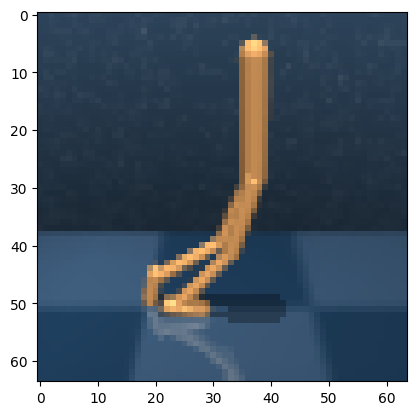

Step  [38]
Action: {'action': array([-0.919823  , -0.9277091 , -0.94820964, -0.9453836 ,  0.7069231 ,
       -0.97446465], dtype=float32), 'logprob': array(6.705097, dtype=float32)}, Reward: 1.9938275325023285, Total Reward: 24.084552673335974


In [ ]:
demonstrate(agent, eval_envs,500)